In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

c:\Users\ekzms\.conda\envs\cooling\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

c:\Users\ekzms\.conda\envs\cooling\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

c:\Users\ekzms\.conda\envs\cooling\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')
c:\Users\ekzms\.conda\envs\cooling\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [8]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

print('Done grouper')
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

Done grouper


In [9]:
from diffusers import DEISMultistepScheduler
scheduler = DEISMultistepScheduler( num_train_timesteps=150, beta_end=0.1, )

In [11]:
estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    # target_dim = int(dataset.metadata.feat_static_cat[0].cardinality),
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=10,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=1, accelerator="gpu", devices="auto"),
    )

In [12]:
predictor = estimator.train(dataset_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\ekzms\.conda\envs\cooling\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


input_size: torch.Size([1, 24, 370])
input_size: torch.Size([1, 24, 370])
prior_input_size: torch.Size([1, 0, 370])
lags_size: torch.Size([1, 24, 370])
time_feat_size: torch.Size([1, 24, 5])
feat_static_cat: torch.Size([1, 1])
embedded_cat: torch.Size([1, 1])
log_abs_loc: torch.Size([1, 370])
log_scale: torch.Size([1, 370])
feat_static_real: torch.Size([1, 1])
static_feat_size: torch.Size([1, 742])
expanded_static_feat_size: torch.Size([1, 24, 742])
features_size: torch.Size([1, 24, 747])
torch.Size([1, 24, 1117])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
------
torch.Size([1, 24, 64])



  | Name  | Type          | Params | In sizes | Out sizes        
-----------------------------------------------------------------------
0 | model | TimeGradModel | 432 K  | ?        | [1, 100, 24, 370]
-----------------------------------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.729     Total estimated model params size (MB)


Epoch 0: : 0it [00:00, ?it/s]input_size: torch.Size([32, 24, 370])
input_size: torch.Size([32, 47, 370])
prior_input_size: torch.Size([32, 0, 370])
lags_size: torch.Size([32, 47, 370])
time_feat_size: torch.Size([32, 47, 5])
feat_static_cat: torch.Size([32, 1])
embedded_cat: torch.Size([32, 1])
log_abs_loc: torch.Size([32, 370])
log_scale: torch.Size([32, 370])
feat_static_real: torch.Size([32, 1])
static_feat_size: torch.Size([32, 742])
expanded_static_feat_size: torch.Size([32, 47, 742])
features_size: torch.Size([32, 47, 747])
torch.Size([32, 47, 1117])
tensor([[[ 0.8469,  0.9123,  0.4271,  ..., -0.5000, -0.4151,  2.8733],
         [ 0.7689,  0.8106,  0.4178,  ..., -0.5000, -0.4151,  2.8739],
         [ 0.8008,  0.7567,  0.4160,  ..., -0.5000, -0.4151,  2.8745],
         ...,
         [ 0.8894,  1.0528,  1.3668,  ..., -0.4667, -0.4123,  2.8982],
         [ 0.8433,  1.0558,  1.2981,  ..., -0.4667, -0.4123,  2.8987],
         [ 0.7689,  0.9990,  0.7057,  ..., -0.4667, -0.4123,  2.8993

Epoch 0, global step 50: 'train_loss' reached 0.38139 (best 0.38139), saving model to 'c:\\Users\\ekzms\\Desktop\\test_pytorchts\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: : 50it [00:20,  2.39it/s, loss=0.336, v_num=4, train_loss=0.381]


In [16]:
rnn_output_ex = torch.rand((1,24,64))

In [17]:
rnn_output_ex.size()

torch.Size([1, 24, 64])

In [18]:
B, T = rnn_output_ex.shape[:2]

In [22]:
rnn_output_ex.reshape(B * T, 1, -1).size()

torch.Size([24, 1, 64])

In [16]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=50)

In [17]:
forecasts = list(forecast_it)
targets = list(ts_it)

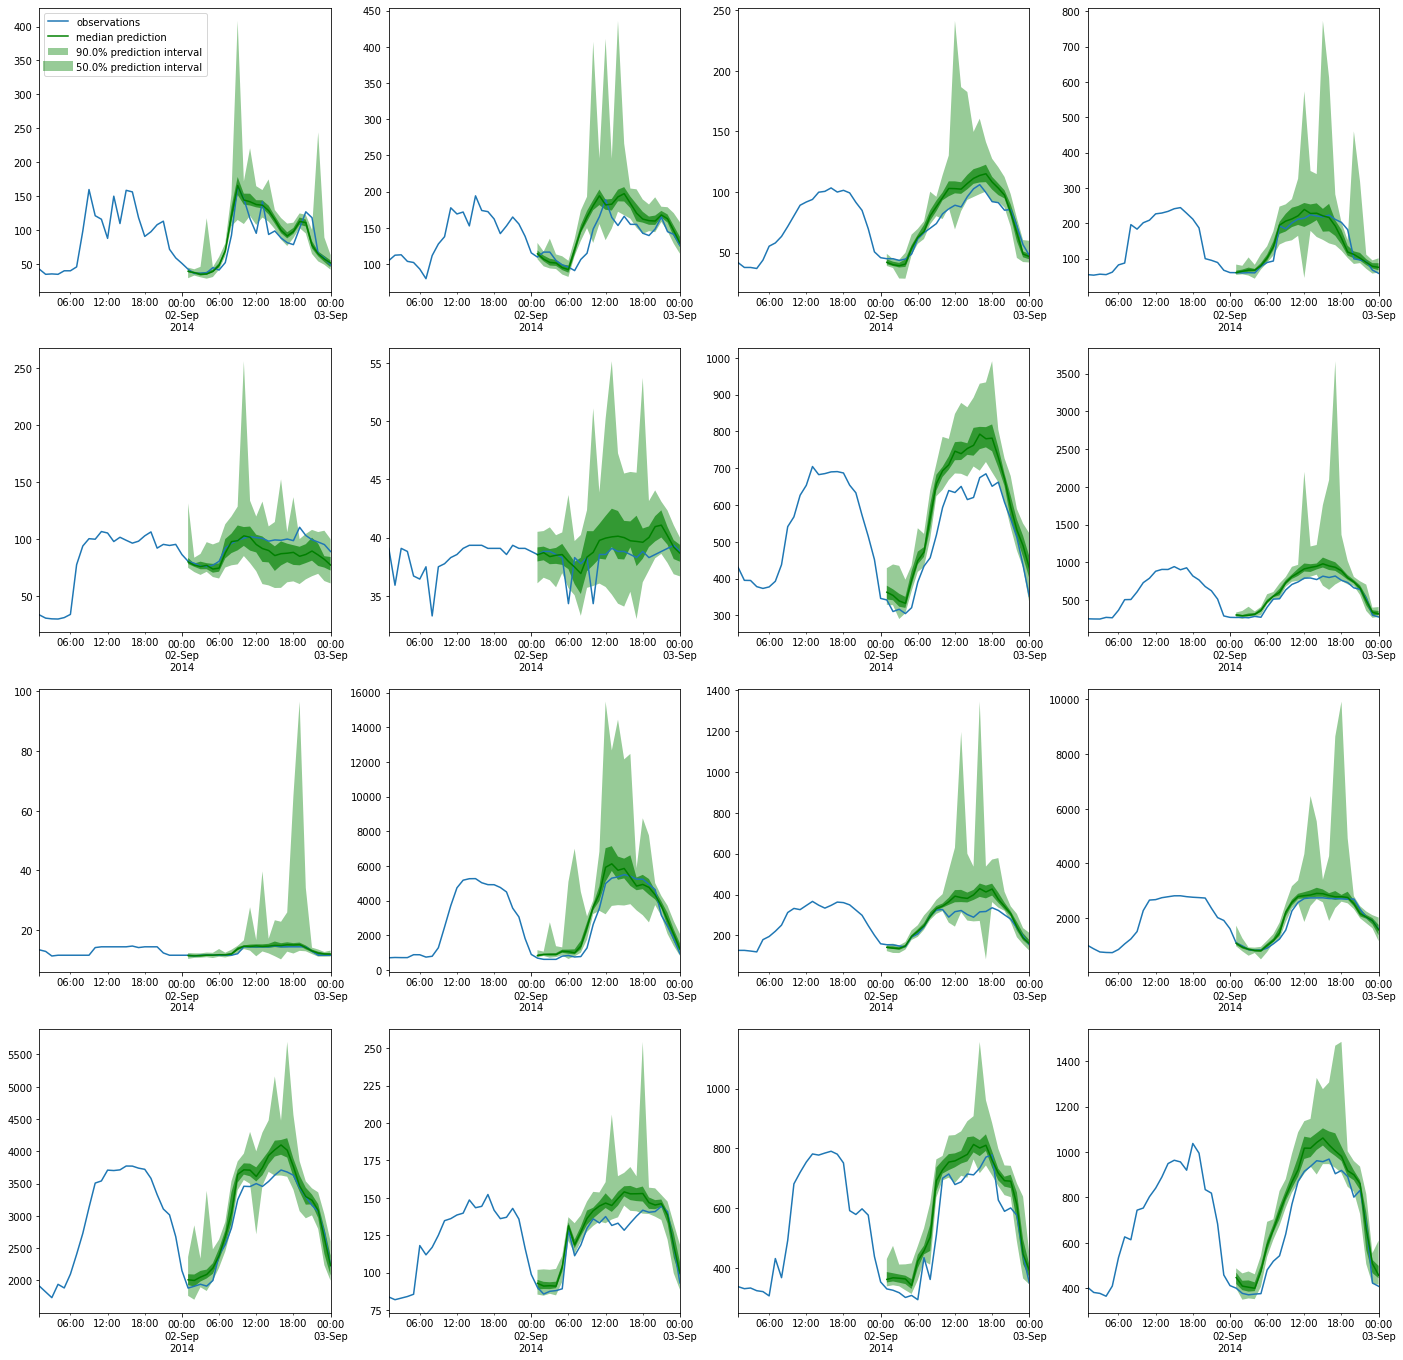

In [18]:
plot(
    target=targets[1],
    forecast=forecasts[1],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()